Image classification with CNN
================

This notebook is based on the exercise notebooks of the course "Introduction to Deep Learning". 

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch.autograd import Variable

from code.data_utils import load_mammography_data
from splitting import split_data

Dataset
=========

* Creating the patches: run the Data_processing_aug.py. Than the patches and the augmented patches will be saved in the folder data.

* Split data in train - val - test data: We get text files in the folder data for train, validation and test set.

In [4]:
#At first we use the data without augmentation.
#For adding the augmented data change the path in the function


##################Uncommented, because it is already done
split_data (train_pro=0.6,val_pro=0.2,test_pro=0.2)

* Load the preprocessed datasets in patches of the same size (input size of network so far 32x32 pixel)

In [5]:
train_data = load_mammography_data('data/train.txt')
val_data = load_mammography_data('data/val.txt')
test_data = load_mammography_data('data/test.txt')

In [6]:
#Printing the size of our sets:
print("Train size: %i" % len(train_data))
print("Val size: %i" % len(val_data))
print("Test size: %i" % len(test_data))

Train size: 70
Val size: 23
Test size: 23


## Train the Network

* Plot validation and training curve
* Hyperparameter optimization

****

In [7]:
from code.classifiers.classification_mammograms import ClassificationMammograms
from code.solver import Solver

best_model = None

num_epochs = 70
batch_size = [32]

learning_rates = [1e-4]

for batch in batch_size:
    train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch, shuffle=True, num_workers=1)
    val_loader = torch.utils.data.DataLoader(val_data, batch_size=batch, shuffle=False, num_workers=1)
    for lr in learning_rates:
        model = ClassificationMammograms()
        solver = Solver(optim_args={"lr": lr, 
                                        #"betas": (0.9, 0.999),
                                        #"eps": 1e-8,
                                        "weight_decay": 0.0})

        solver.train(model, train_loader, val_loader, log_nth=1000, num_epochs=num_epochs)
        print(lr,batch)
            


START TRAIN.
[Epoch 1/70] TRAIN loss: 4.146122455596924, acc: 0.1111111111111111
[Epoch 1/70] VAL loss: 2.2060179710388184, acc: 0.43478260869565216
[Epoch 2/70] TRAIN loss: 1.077836036682129, acc: 0.5729166666666666
[Epoch 2/70] VAL loss: 0.976707935333252, acc: 0.4782608695652174
[Epoch 3/70] TRAIN loss: 1.3783063888549805, acc: 0.46527777777777773
[Epoch 3/70] VAL loss: 1.0872161388397217, acc: 0.43478260869565216
[Epoch 4/70] TRAIN loss: 0.6647793650627136, acc: 0.6180555555555555
[Epoch 4/70] VAL loss: 1.016652226448059, acc: 0.43478260869565216
[Epoch 5/70] TRAIN loss: 0.9311272501945496, acc: 0.5208333333333334
[Epoch 5/70] VAL loss: 0.8073232173919678, acc: 0.5217391304347826
[Epoch 6/70] TRAIN loss: 0.6276664733886719, acc: 0.6597222222222222
[Epoch 6/70] VAL loss: 0.8106170892715454, acc: 0.4782608695652174
[Epoch 7/70] TRAIN loss: 0.2589559555053711, acc: 0.8229166666666666
[Epoch 7/70] VAL loss: 0.830074667930603, acc: 0.43478260869565216
[Epoch 8/70] TRAIN loss: 0.72245818

[Epoch 61/70] TRAIN loss: 0.025563716888427734, acc: 1.0
[Epoch 61/70] VAL loss: 3.5234899520874023, acc: 0.4782608695652174
[Epoch 62/70] TRAIN loss: 0.01694122888147831, acc: 1.0
[Epoch 62/70] VAL loss: 3.7547080516815186, acc: 0.4782608695652174
[Epoch 63/70] TRAIN loss: 0.0030215580482035875, acc: 1.0
[Epoch 63/70] VAL loss: 3.847607374191284, acc: 0.4782608695652174
[Epoch 64/70] TRAIN loss: 0.002241452457383275, acc: 1.0
[Epoch 64/70] VAL loss: 4.067275047302246, acc: 0.43478260869565216
[Epoch 65/70] TRAIN loss: 0.012064933776855469, acc: 1.0
[Epoch 65/70] VAL loss: 4.125112533569336, acc: 0.4782608695652174
[Epoch 66/70] TRAIN loss: 0.007825374603271484, acc: 1.0
[Epoch 66/70] VAL loss: 4.023440837860107, acc: 0.4782608695652174
[Epoch 67/70] TRAIN loss: 2.7020772904506885e-05, acc: 1.0
[Epoch 67/70] VAL loss: 4.46533203125, acc: 0.43478260869565216
[Epoch 68/70] TRAIN loss: 9.854634299699683e-06, acc: 1.0
[Epoch 68/70] VAL loss: 4.99526834487915, acc: 0.43478260869565216
[Epoc

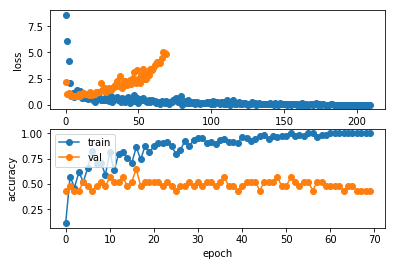

In [8]:
plt.subplot(2, 1, 1)
plt.plot(solver.train_loss_history, 'o')
plt.plot(solver.val_loss_history, 'o')
plt.xlabel('iteration')
plt.ylabel('loss')

plt.subplot(2, 1, 2)
plt.plot(solver.train_acc_history, '-o')
plt.plot(solver.val_acc_history, '-o')
plt.legend(['train', 'val'], loc='upper left')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.show()

* Visualize filters to see if network learns meaningful features

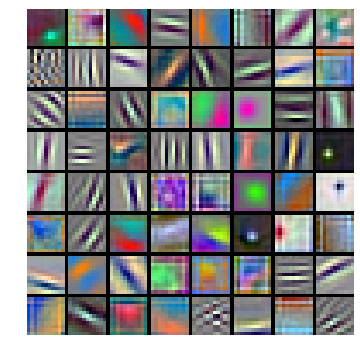

In [9]:
from code.vis_utils import visualize_grid

# first (next) parameter should be convolutional
conv_params = next(model.parameters()).cpu().data.numpy()
grid = visualize_grid(conv_params.transpose(0, 2, 3, 1))
plt.imshow(grid.astype('uint8'))
plt.axis('off')
plt.gcf().set_size_inches(6, 6)
plt.show()

# Test your Model


* Visualization of the test dataset

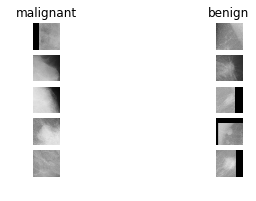

In [10]:
classes = ['malignant', 'benign']
num_classes = len(classes)
samples_per_class = 7
for cls_idx, cls in enumerate(classes):
    cls_data = [datum for datum in test_data if datum[1] == cls_idx]
    rnd_idxs = np.random.randint(0, len(cls_data), samples_per_class)
    rnd_cls_data = [datum for i, datum in enumerate(cls_data) if i in rnd_idxs]
    for i, cls_datum in enumerate(rnd_cls_data):
        plt_idx = i * num_classes + cls_idx + 1
        plt.subplot(samples_per_class, num_classes, plt_idx)
        plt.imshow(cls_datum[0].numpy().transpose(1,2,0))# + mean_image.transpose(1,2,0))
        plt.axis('off')
        if i == 0:
            plt.title(cls)
plt.show()

* Running our model on the test dataset

In [11]:
from code.classifiers.classification_mammograms import ClassificationMammograms
from code.solver import Solver

test_loader = torch.utils.data.DataLoader(test_data, batch_size=140, shuffle=False, num_workers=4)

scores = []
model.eval()
for inputs, targets in test_loader:
   # inputs, targets = inputs.to(device), targets.to(device)
    print('Input size:',inputs.size())
    print('Target size:',targets.size())
    
    outputs = model(inputs)
    #print('out')
    _, preds = torch.max(outputs, 1)
    scores.extend(preds.cpu().numpy() == targets.cpu().numpy())

print('Test set accuracy: %f' % np.mean(scores))

Input size: torch.Size([23, 3, 240, 240])
Target size: torch.Size([23])
Test set accuracy: 0.478261
